# Download Data

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
src_dir = os.path.join(nb_dir, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

from data.make_dataset import download_dataset, create_hdf

Execute `make data` or this cell first to import data.

In [2]:
# download_dataset()
# create_hdf()

# Import Data

In [3]:
import pandas as pd

df = pd.read_hdf('../data/processed/train.hdf', key='data')

We select a subset of the data. Also, id3=610 is way too often, let's drop it.

In [4]:
#df = df[~(df["id3"] == 610)].sample(frac=.1)

In [5]:
minDay = df["date"].min()
maxDay = df["date"].max()
print(minDay, maxDay)

1 54


In [6]:
df[:5]

,id3,user_id,id2,date,id1
0,714,464300,34,1,4
1,714,915655,34,1,4
2,316,262696,42,1,2
3,52,354280,4,1,10
4,581,218912,14,1,10


In [7]:
df.count()

id3        46996828
user_id    46996828
id2        46996828
date       46996828
id1        46996828
dtype: int64

# Train-Test-Split

In [8]:
train = df[df["date"] <= maxDay - 7]
test = df[df["date"] > maxDay - 7]

In [9]:
print(train["id1"].count(), test["id1"].count())

43522727 3474101


In [10]:
minDayTest = test["date"].min()
maxDayTest = test["date"].max()
print(minDayTest, maxDayTest)

48 54


In [11]:
minDayTrain = train["date"].min()
maxDayTrain = train["date"].max()
print(minDayTrain, maxDayTrain)

1 47


# Create Hash Maps

In [12]:
def parentIds(df):
    id32 = df.groupby(["id3"])["id2"].max().to_dict()
    id21 = df.groupby(["id2"])["id1"].max().to_dict()
    return id21, id32

In [13]:
id21, id32 = parentIds(train[:10])
print(id21, id32)

{49: 4, 34: 4, 3: 6, 4: 10, 37: 6, 42: 2, 58: 6, 14: 10, 63: 9} {52: 4, 581: 14, 279: 49, 714: 34, 783: 58, 316: 42, 590: 63, 254: 37, 613: 3}


In [14]:
id21, id32 = parentIds(train)
print(len(id21), len(id32))

122 924


In [15]:
def userIds(df):
    userToId3 = df.groupby(["user_id"])["id3"].apply(lambda x: list(set(x))).to_dict()
    id3ToUser = {i: [] for i in id32}
    for user, tid3s in userToId3.items():
        for i in tid3s:
            id3ToUser[i].append(user)
    return userToId3, id3ToUser

In [16]:
userToId3, id3ToUser = userIds(train[:10])
print(userToId3)

{218912: [581], 354280: [52], 14946: [783, 279], 1072612: [254], 1029729: [590], 915655: [714], 262696: [316], 638732: [613], 464300: [714]}


In [17]:
userToId3, id3ToUser = userIds(train)
print(len(userToId3), len(id3ToUser))

989245 924


In [18]:
def userVisits(df):
    userId3Visits = df.groupby(["user_id", "date"])["id3"].apply(lambda x: list(set(x))).to_dict()
    return userId3Visits

In [19]:
userId3Visits = userVisits(train[:10])
print(userId3Visits)

{(218912, 1): [581], (354280, 1): [52], (464300, 1): [714], (915655, 1): [714], (262696, 1): [316], (638732, 1): [613], (1072612, 1): [254], (1029729, 1): [590], (14946, 1): [783, 279]}


In [20]:
userId3Visits = userVisits(train)
print(len(userId3Visits))

7450443


In [21]:
id3Visits = train["id3"].value_counts().to_dict()
id3s = sorted(train["id3"].unique(), key=lambda i: -id3Visits[i])
print(len(id3s))

924


In [22]:
#print(id3s, id3Visits)

# Fix one Id3, look at the distribution of visits before

In [35]:
def profile(user, day, duration=7):
    id3Visited = []
    for d in range(max(0, day - duration), day):
        if (user, d) in userId3Visits:
            id3Visited += userId3Visits[(user, d)]
    return [id3Visited.count(i) for i in id3s]

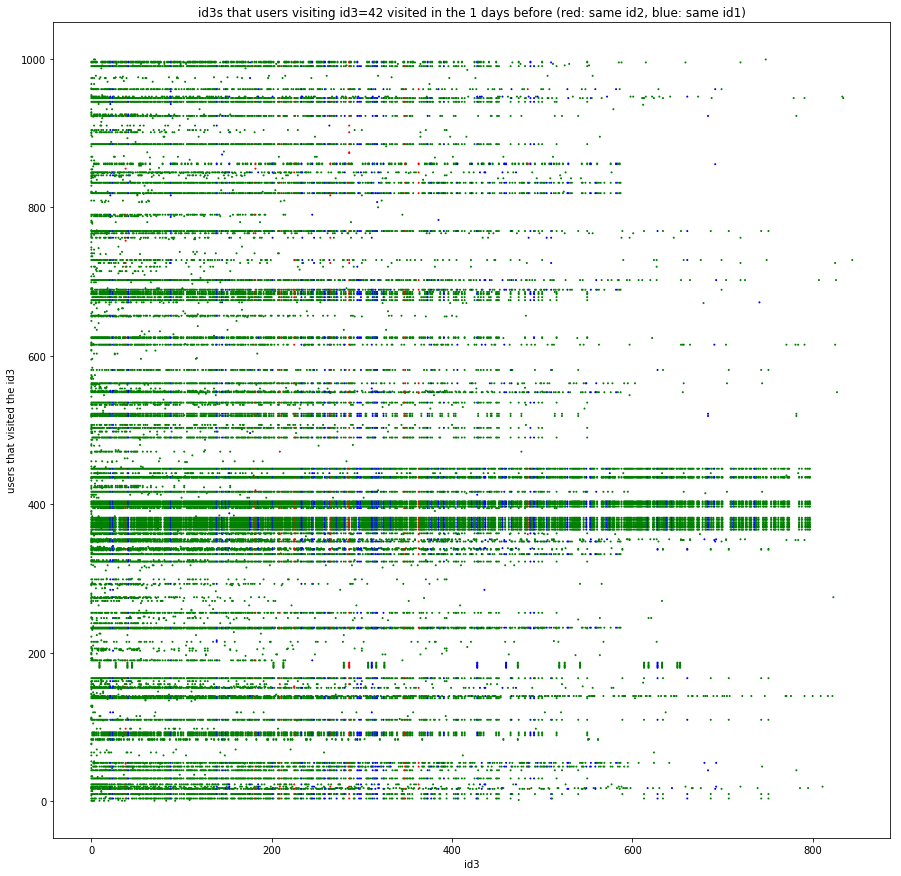

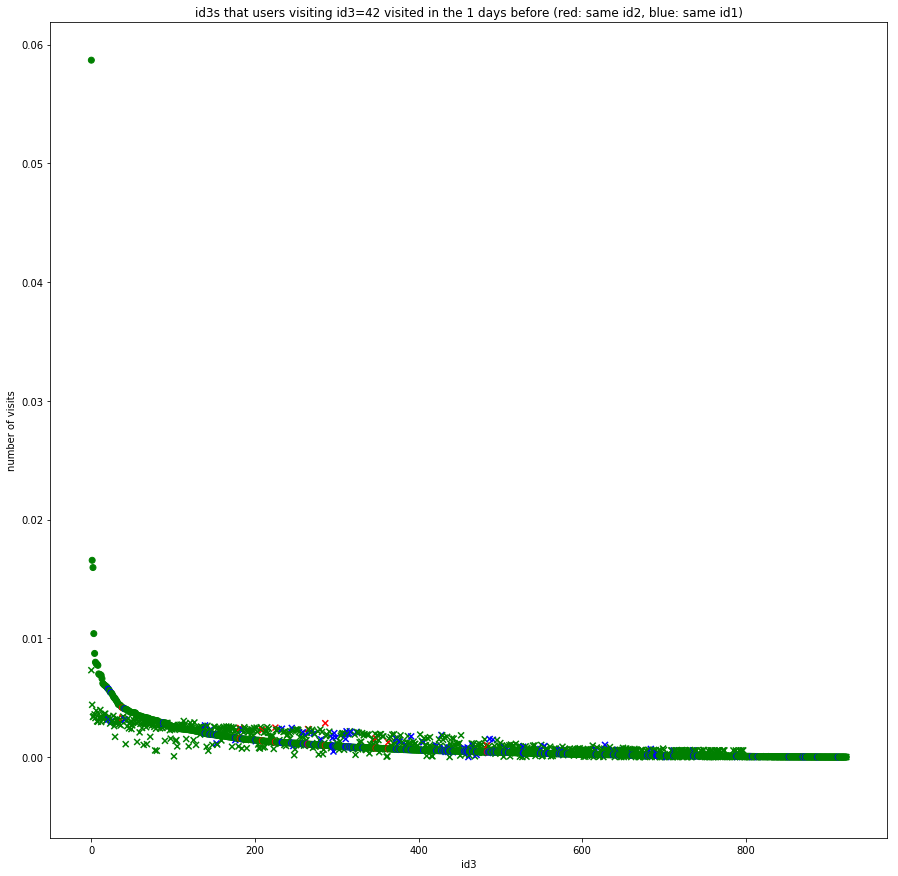

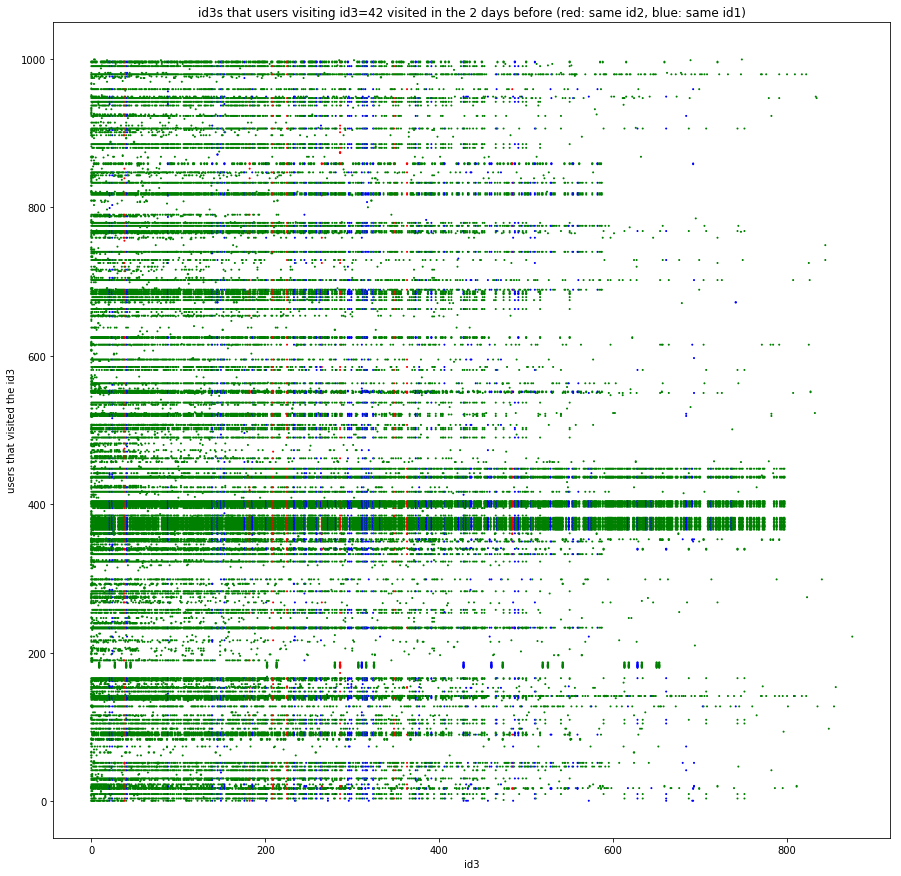

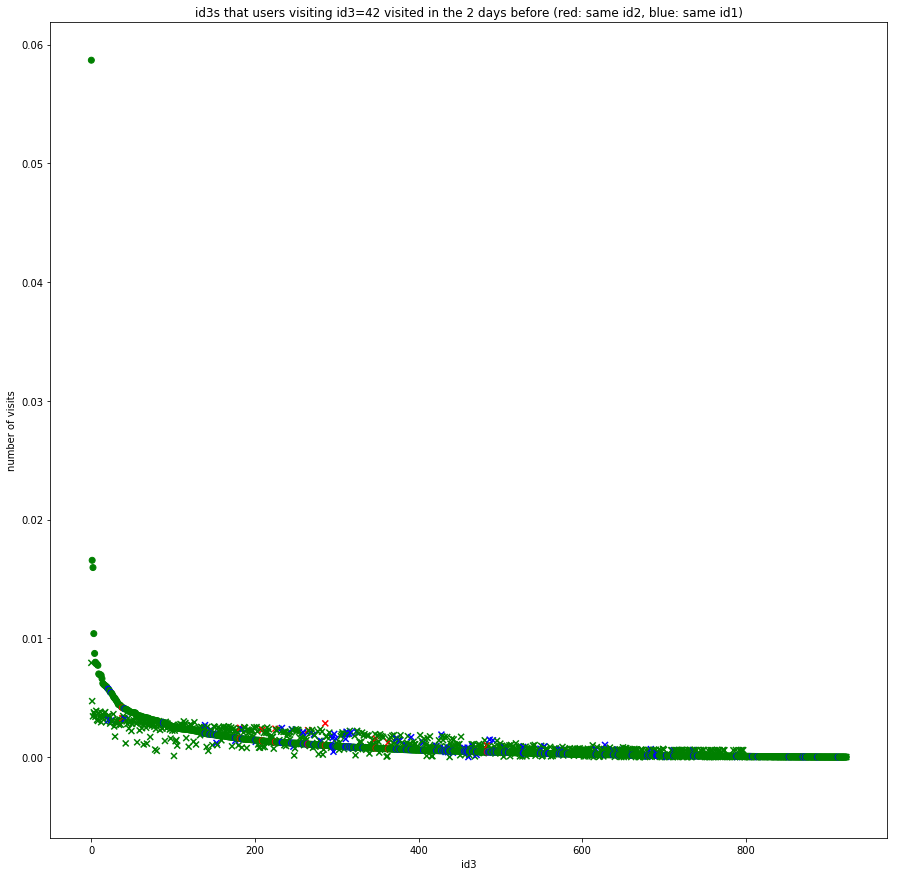

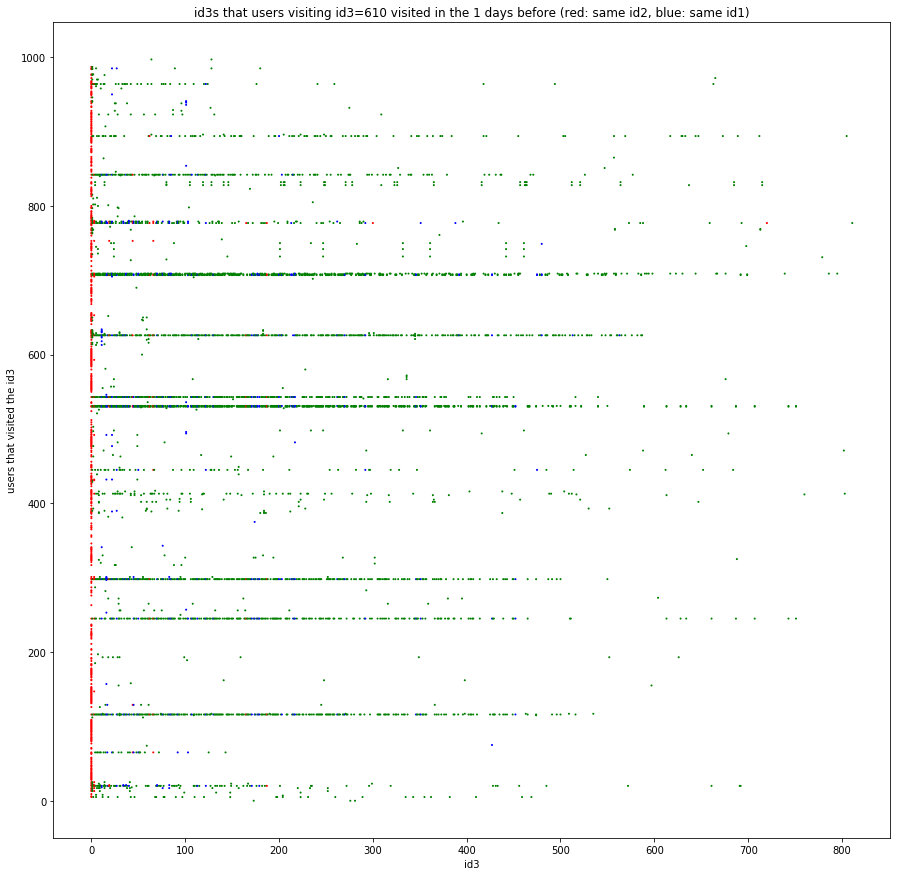

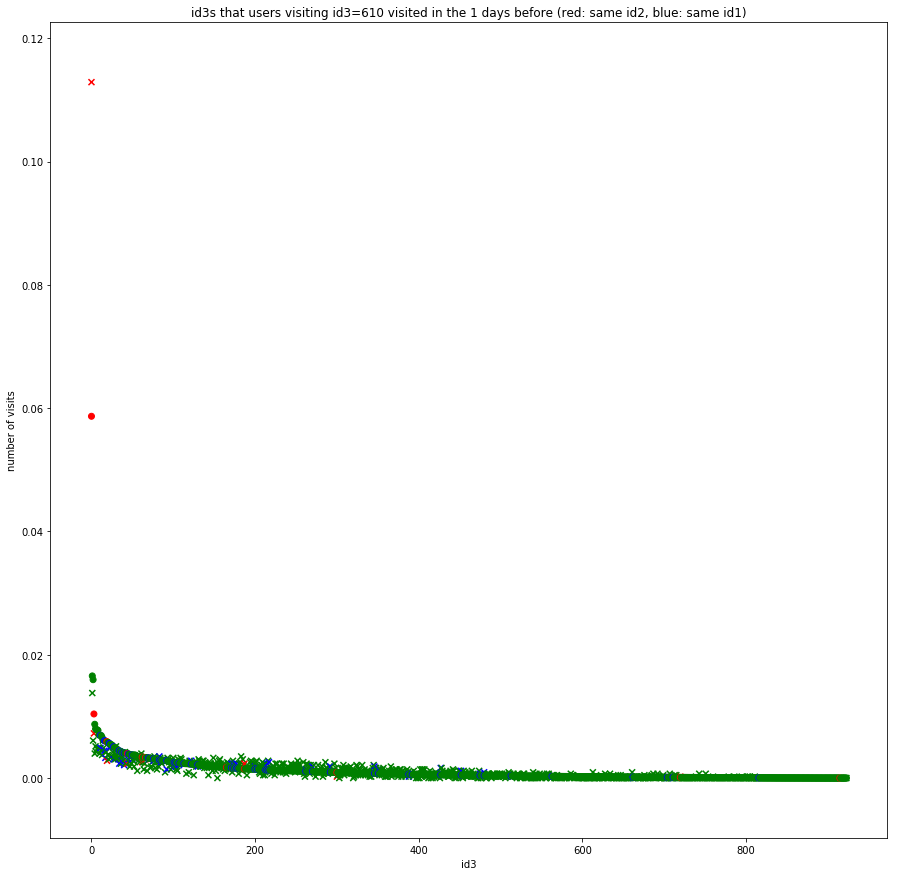

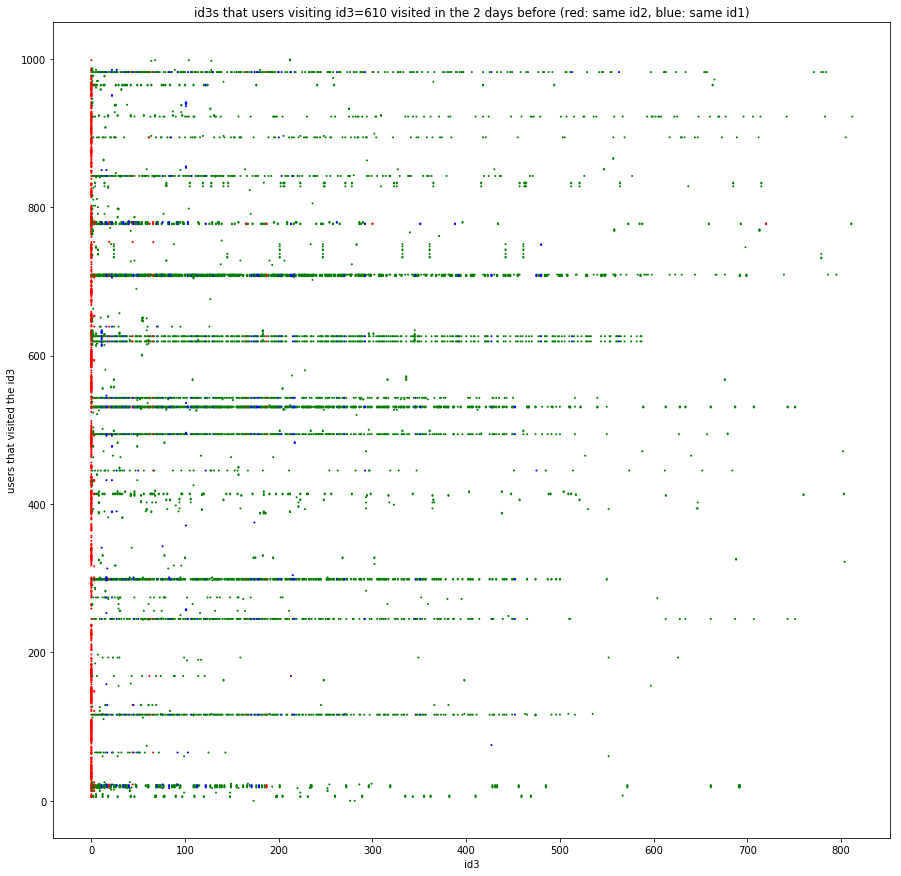

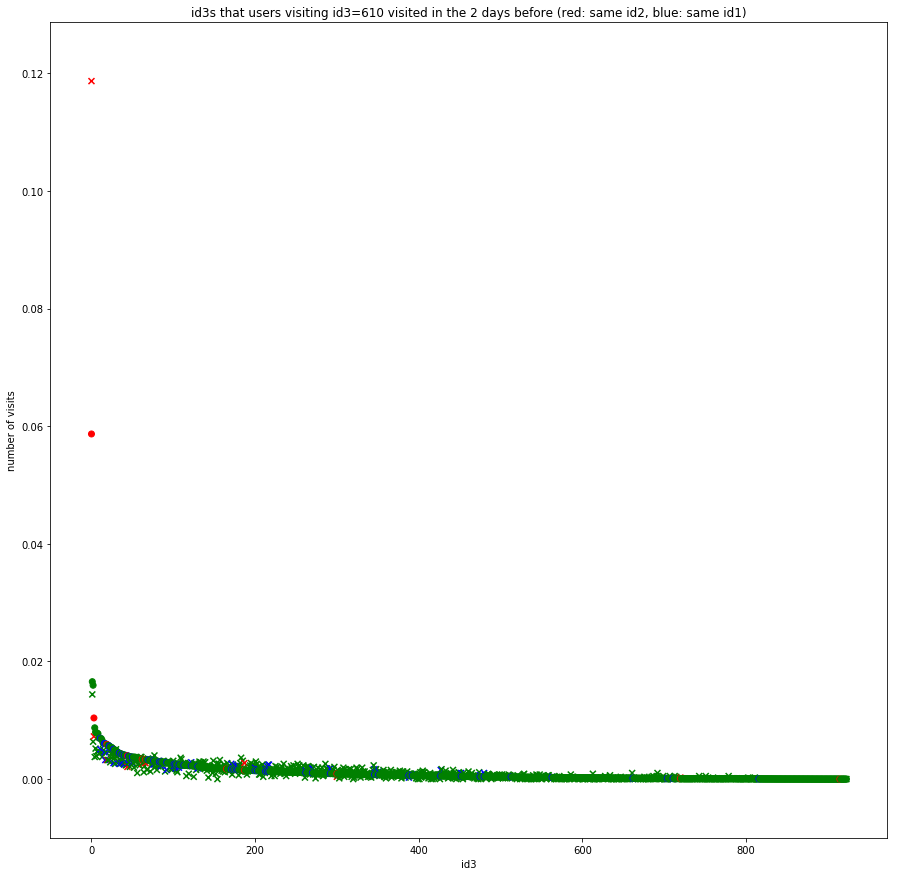

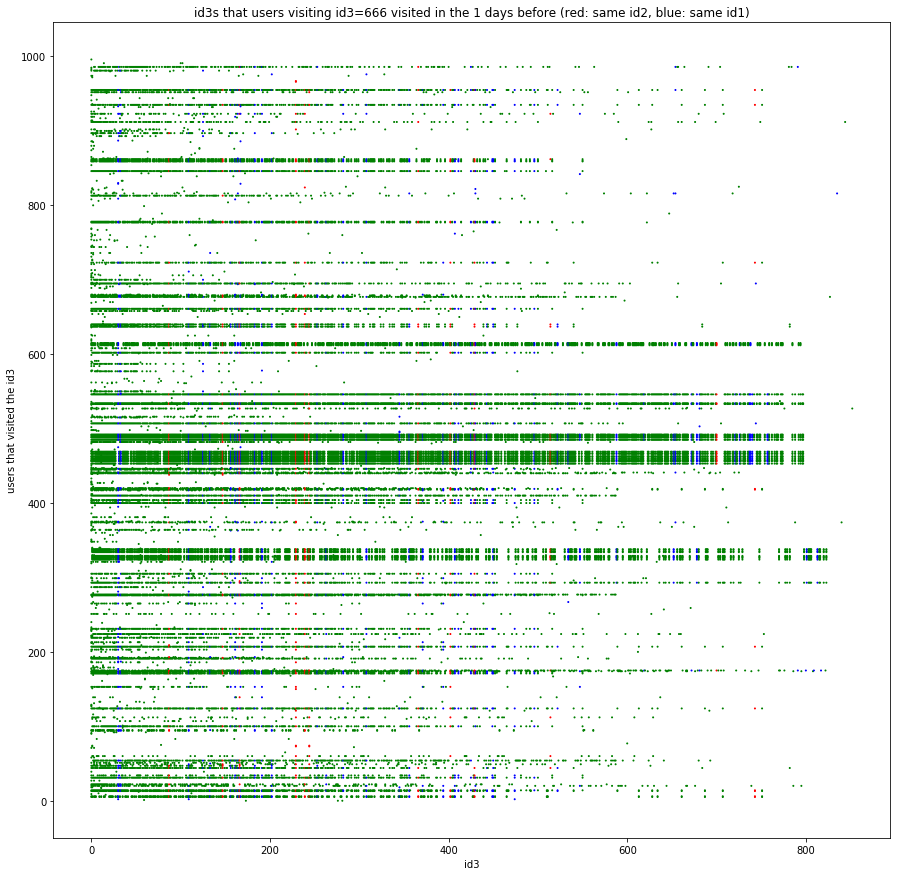

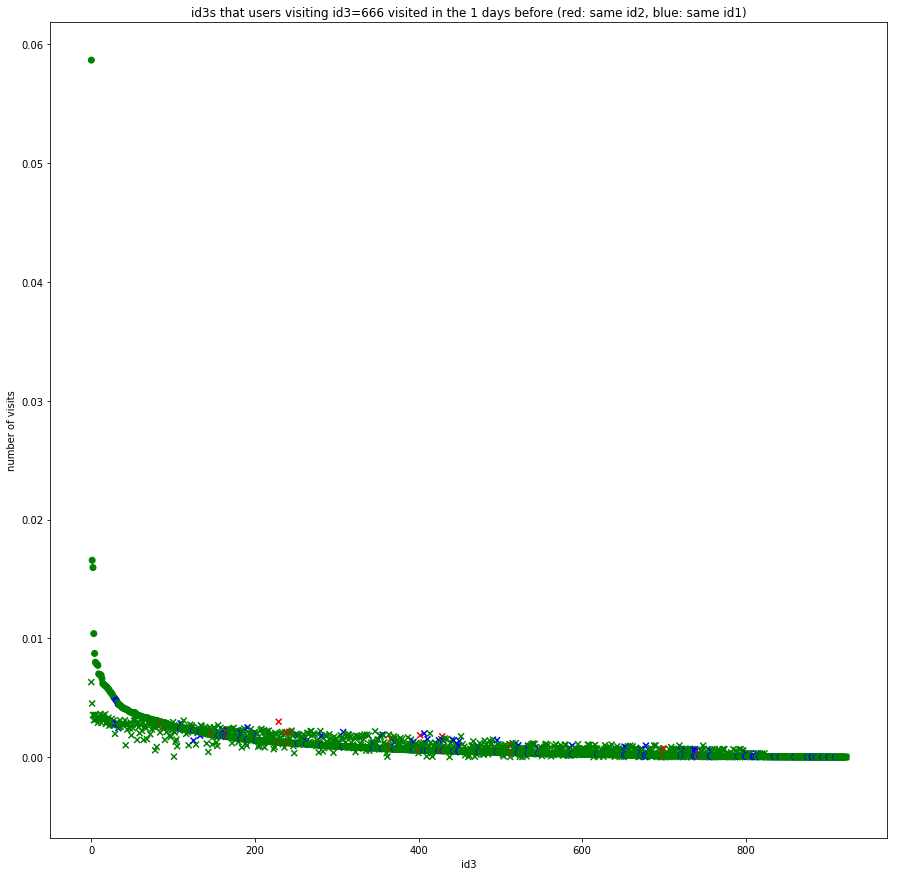

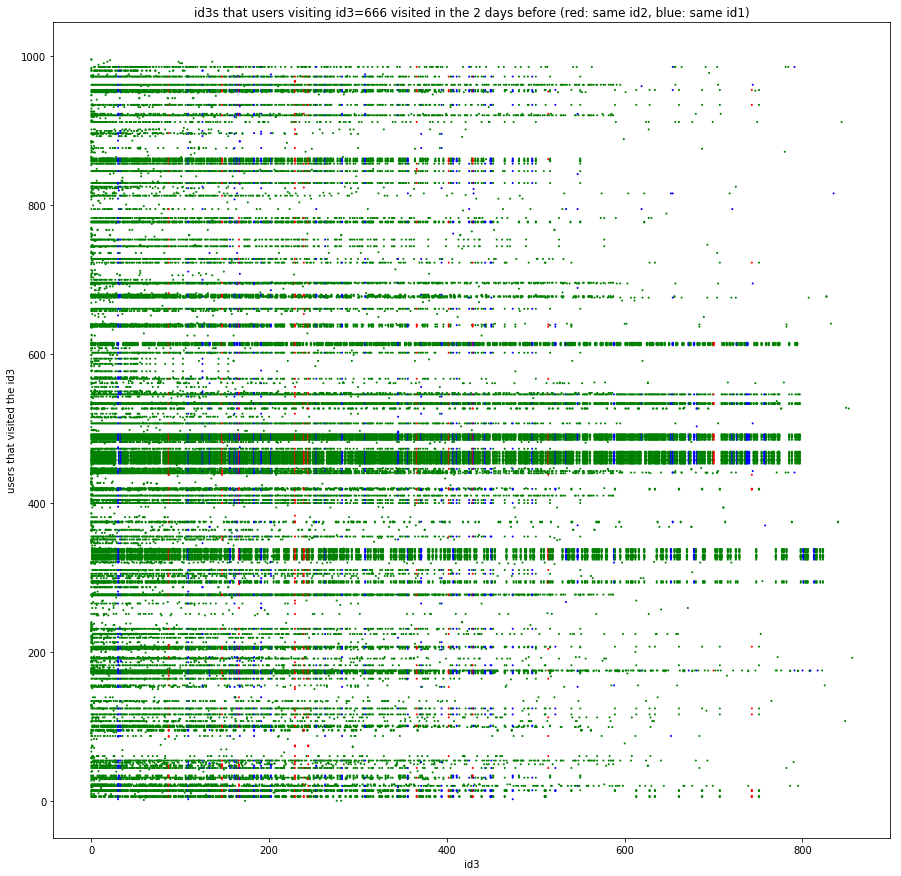

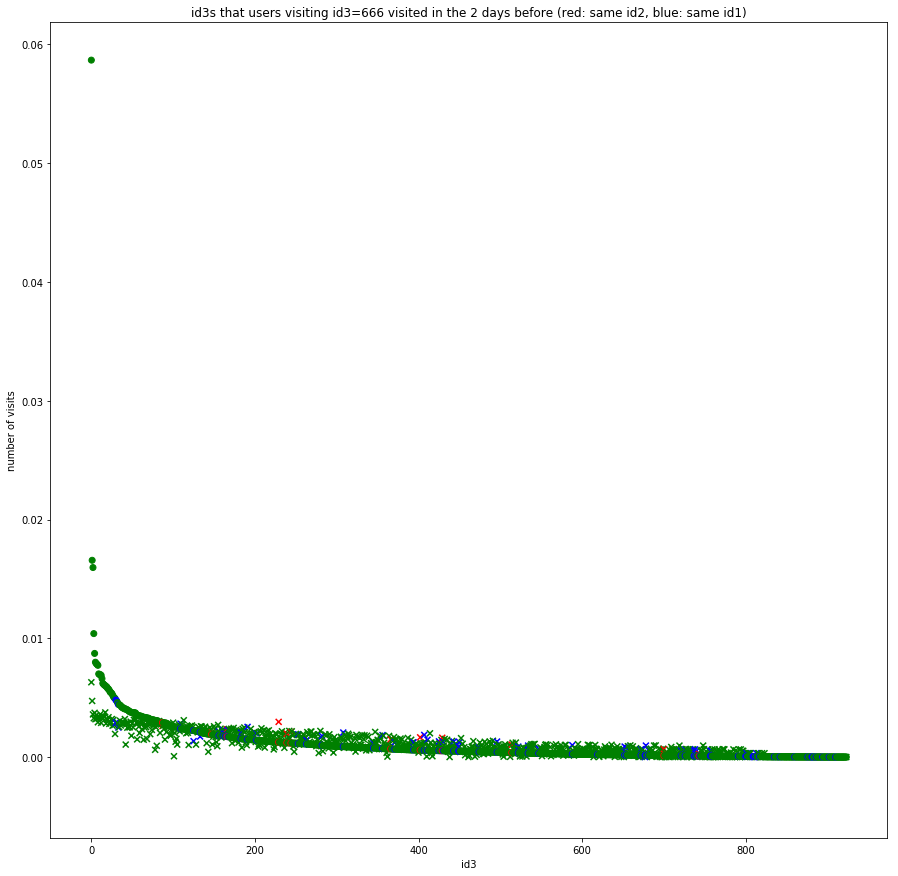

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 15)

for id3 in [42, 610, 666]:
    for duration in range(1, 3):
        X = []
        for user in id3ToUser[id3]:
            for day in range(minDayTrain, maxDayTrain + 1):
                if len(X) < 1000: #break when chart is full
                    if (user, day) in userId3Visits and id3 in userId3Visits[(user, day)]:
                        X.append(profile(user, day, duration=duration))

        scatterx, scattery, scatters, scatterc = [], [], [], []
        for i in range(len(X)):
            for j in range(len(X[i])):
                if X[i][j]:
                    scatterx.append(j)
                    scattery.append(i)
                    scatters.append(1 * X[i][j])
                    id1Same = id21[id32[id3s[j]]] == id21[id32[id3]]
                    id2Same = id32[id3s[j]] == id32[id3]
                    if id2Same:
                        scatterc.append("r")
                    elif id1Same:
                        scatterc.append("b")
                    else:
                        scatterc.append("g")
        plt.scatter(scatterx, scattery, s=scatters, c=scatterc)
        plt.xlabel("id3")
        plt.ylabel("users that visited the id3")
        plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
        plt.show()

        totalVisits = [0 for _ in id3s]
        for i in range(len(X)):
            for j in range(len(X[i])):
                totalVisits[j] += X[i][j]
        sumTotalVisits = sum(totalVisits)
        totalVisits = [i/sumTotalVisits for i in totalVisits]

        sumAllVisits = sum(id3Visits.values())
        allVisits = [id3Visits[i]/sumAllVisits for i in id3s]

        visitsc = []
        for i in id3s:
            id1Same = id21[id32[i]] == id21[id32[id3]]
            id2Same = id32[i] == id32[id3]
            if id2Same:
                visitsc.append("r")
            elif id1Same:
                visitsc.append("b")
            else:
                visitsc.append("g")


        plt.scatter([i for i in range(len(id3s))], totalVisits, c=visitsc, marker="x")
        plt.scatter([i for i in range(len(id3s))], allVisits, c=visitsc)
        plt.xlabel("id3")
        plt.ylabel("number of visits")
        plt.title("id3s that users visiting id3={} visited in the {} days before (red: same id2, blue: same id1)".format(id3, duration))
        plt.show()